## Entrenamiento del Modelo

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [6]:
dataset = np.load("proyecto_training_data.npy")

### 2. Usando sclicing con NumPy separar los datos en 2 datasets: entrenamiento(80 %) y validación y pruebas(20 %).

In [7]:
# Obtenemos un entero que nos indica en que posición del array podemos obtener el 80%
sliceIndex = int(dataset.shape[0] * 0.8)

# Modifica el orden de las filas
np.random.shuffle(dataset)

# Seleccionamos el 80% para el entrenamiento
dataset_entrenamiento = dataset[:sliceIndex]

# Seleccionamos el 20% para la validación
dataset_validacion = dataset[sliceIndex:]

### 3. Análisis exploratorio de datos: Para cada variable en el dataset calcular((usando numpy o pandas):

In [9]:
columnas = ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']

dfEntrenamiento = pd.DataFrame(dataset_entrenamiento, columns=columnas)
dfValidacion = pd.DataFrame(dataset_validacion, columns=columnas)

columnas = ['Media', 'Minimo', 'Maximo', 'ValorPeak', 'DesviacionEstandar']

dfAnalisis = pd.DataFrame(columns=columnas)

dfAnalisis['Media'] = dfEntrenamiento.mean()
dfAnalisis['Minimo'] = dfEntrenamiento.min()
dfAnalisis['Maximo'] = dfEntrenamiento.max()
dfAnalisis['ValorPeak'] = dfAnalisis['Maximo'] - dfAnalisis['Minimo']
dfAnalisis['DesviacionEstandar'] = dfEntrenamiento.std()

In [10]:
dfAnalisis.head()

,Media,Minimo,Maximo,ValorPeak,DesviacionEstandar
SalePrice,181520.429795,34900.0,755000.0,720100.0,78673.112146
OverallQual,6.125856,1.0,10.0,9.0,1.383121
1stFlrSF,1158.693493,334.0,4692.0,4358.0,386.578738
TotRmsAbvGrd,6.520548,2.0,14.0,12.0,1.600532
YearBuilt,1971.323630,1872.0,2010.0,138.0,30.719446


### 4. Para cada variable en el dataset usar seaborn para graficar un histograma de la variable.

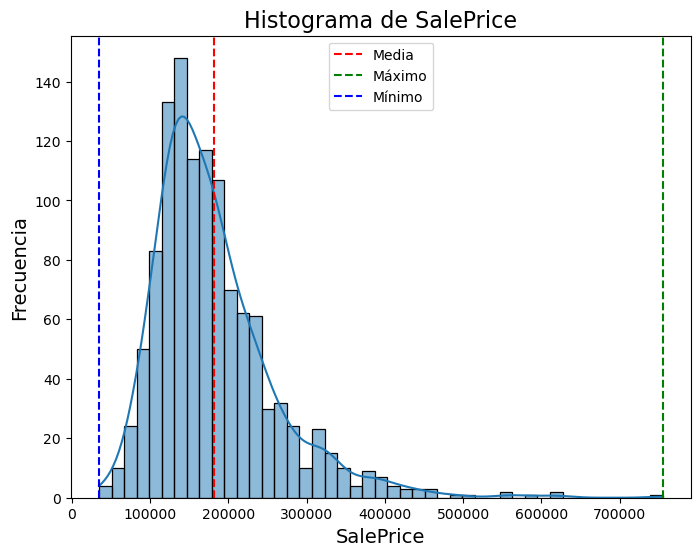

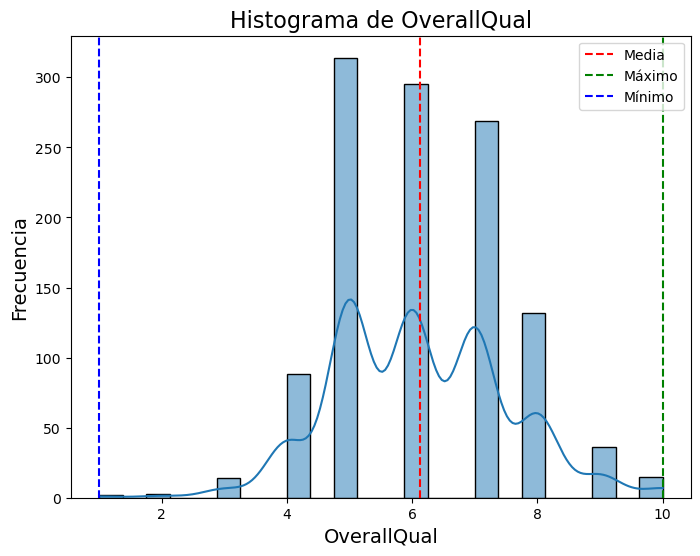

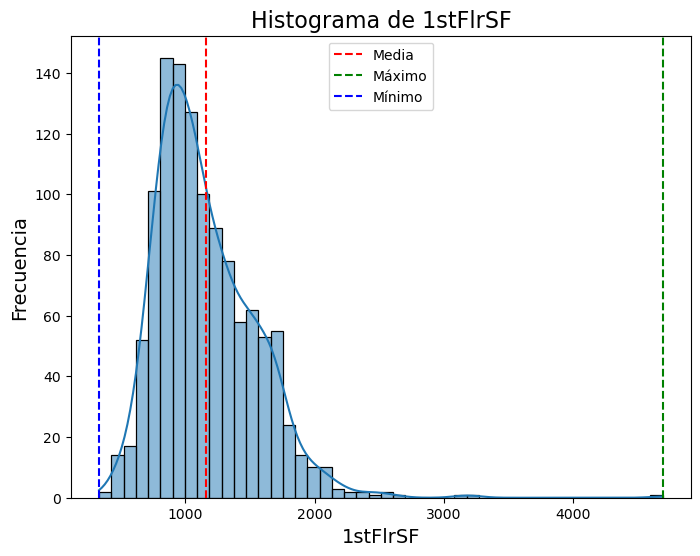

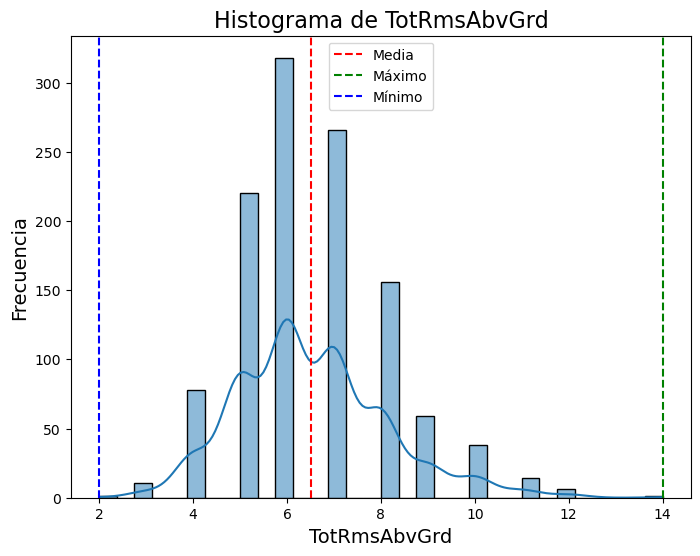

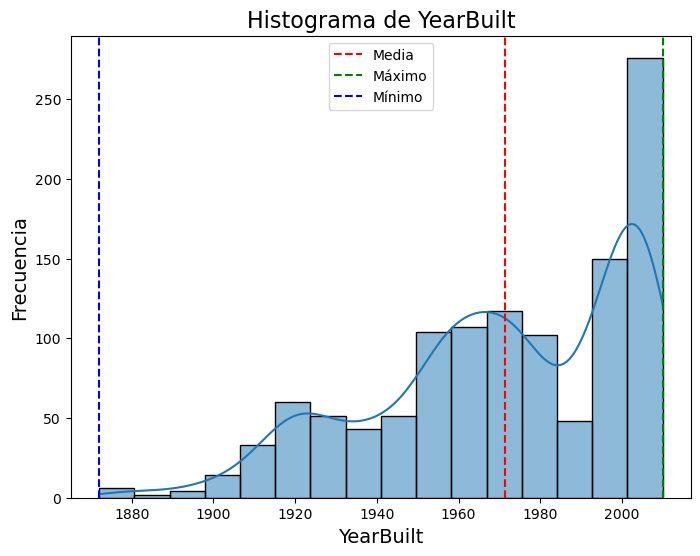

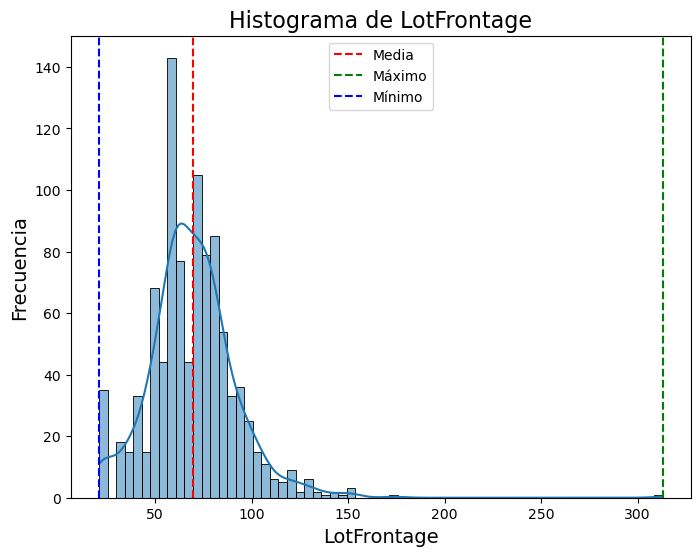

In [11]:
for col in dfEntrenamiento.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(dfEntrenamiento[col], kde=True)
    plt.title(f'Histograma de {col}', fontsize=16)
    
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)

    plt.axvline(dfAnalisis.loc[col, 'Media'], color='red', linestyle='--', label='Media')
    plt.axvline(dfAnalisis.loc[col, 'Maximo'], color='green', linestyle='--', label='Máximo')
    plt.axvline(dfAnalisis.loc[col, 'Minimo'], color='blue', linestyle='--', label='Mínimo')
    
    plt.legend()
    plt.show()

### 5. Para cada variable independiente x:

#### Calcular el coeficiente de correlación entre X y Y.
#### Graficar x vs y(scatterplot) usando matplotlib.
#### Colocar el coeficiente de correlación y colocarlo como parte del título de la gráfica.

In [12]:
def calcular_cociente_correlacion(df):
    dfCorrelacionVariables = df.corr()
    dfCorrelacionVariables.head()

    # SalePrice es la variable Y, por lo que se excluye de las X.

    variablesX = ['OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']
    variableY = 'SalePrice'

    for variableX in variablesX:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=variableX, y=variableY, data=dfEntrenamiento)
        coeficiente = dfCorrelacionVariables.loc[[variableX], [variableY]].iloc[0,0]
        plt.title(f"{variableX} - {variableY} - {coeficiente}", fontsize=16)
        plt.xlabel(variableX, fontsize=14)
        plt.ylabel(variableY, fontsize=14)
        plt.grid(True)
        plt.show()
    
    return dfCorrelacionVariables

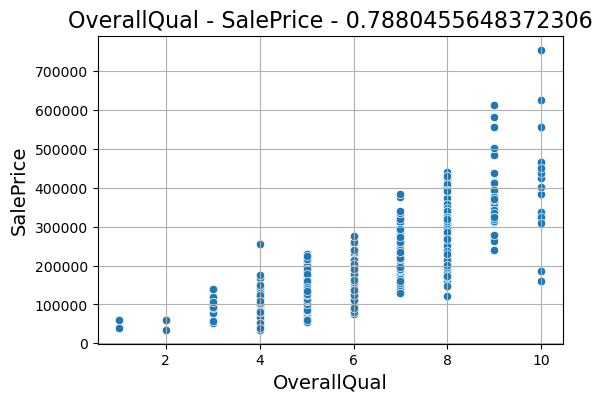

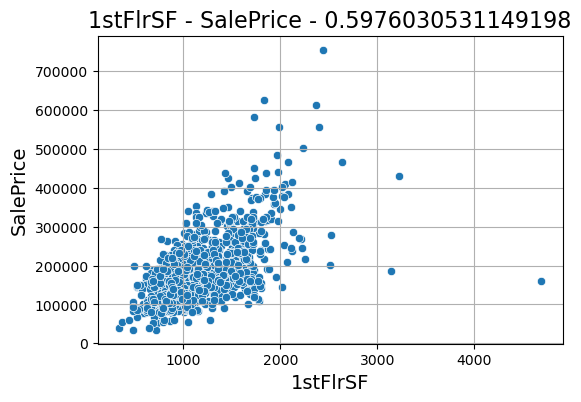

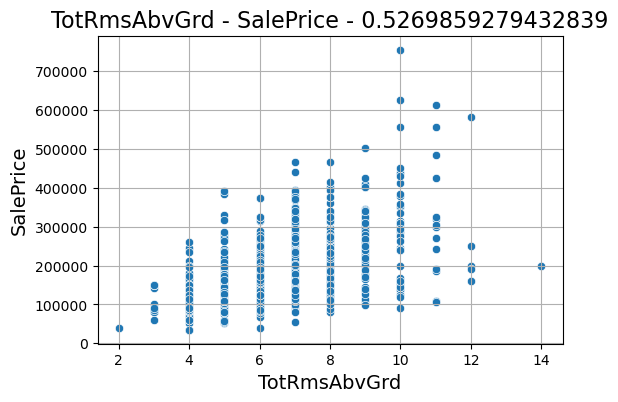

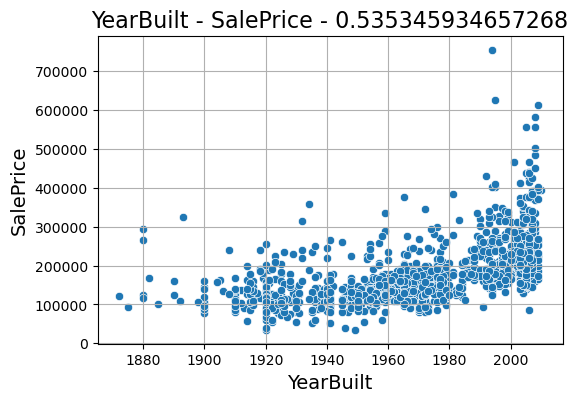

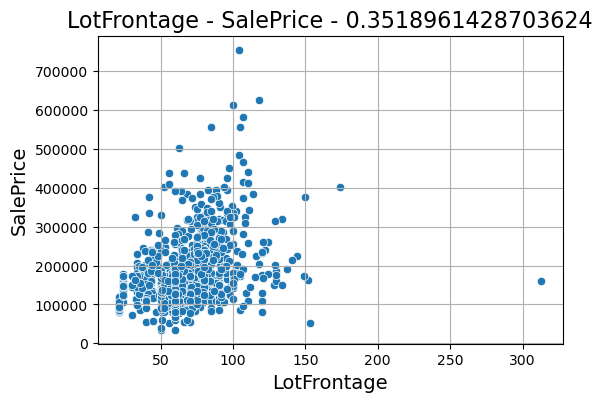

In [14]:
dfCorrelacionVariables = calcular_cociente_correlacion(dfEntrenamiento)

#### Basado en la gráfica y el coeficiente de correlación de cada par x,y elegir las 2 variables con más potencial predictivo es decir las 2 variables que presentan mayor correlación entre dicha variable y la variable dependiente.

#### Segun los diagramas y el dataframe de correlacion de variables, las variables que presentan una mayor correlacion son:
#### 1. X (OverallQual) => Y (SalePrice)
#### 2. X (1stFlrSF) => Y (SalePrice)

In [15]:
dfCorrelacionVariables.loc[['OverallQual', '1stFlrSF'], ['SalePrice']]

,SalePrice
OverallQual,0.788046
1stFlrSF,0.597603


### 6. Crear una función para entrenar un modelo de regresión lineal de una variable y = β0 + β1 ∗ x.

##### La función recibe como argumentos:
##### 6.1 Vector con la variable independiente x,
##### 6.2 Vector con la variable dependiente y,
##### 6.3 un entero epochs que indica por cuantas iteraciones entrenar el modelo.
##### 6.4 un entero imprimir error cada, que nos indica cada cuantas iteraciones queremos imprimir a través de print: el número de iteración, el error del modelo en esa iteración, si imprimir error cada = 10, se despliega en pantalla el error en las iteraciones: 10,20,30,40,50.
##### 6.5 escalar α(learning rate): es usado como parte de la expresión matemática para actualizar en cada iteración los parámetros del modelo.

In [125]:
class Regresion:
    y_pred_manual = []
    y_pred_sklearn = []
    error_sklearn = None
    
    #def __init__(self):
    
    def calcular_rmse(self, y, y_pred):
        num = len(y)
        suma_error_cuadratico = sum((y[i] - y_pred[i]) ** 2 for i in range(num))
        result = suma_error_cuadratico / num
        return result ** 0.5

    def calcular_gradiente(self, x, y, epochs, imprimir_error, learning_rate):
        
        # Crear una matriz de 2 columnas, la primera columna corresponde al vector de datos x 
        # y la segunda columna de la matriz para todas las filas es igual a 1.
        observaciones = np.column_stack((x, np.ones_like(x)))
        
        # Inicializar los parámetros del modelo en un vector β0 y β1, esto es equivalente a empezar el proceso con una recta inicial 
        # la cual en cada iteración actualizaremos hasta encontrar una que aproxime de buena manera los datos x, y.
        parametros = np.array([0.01, 0.1])
        
        n = len(x)
        historial_parametros = {}
        historial_error = {}
        
        mostrar_error = 0
        
        # iterar las epocas
        for i in range(1, epochs + 1):
            
            # Calcular y (prediccioón o estimación) para todas las observaciones de manera simultánea(vectorizada) 
            # utilizando el modelo correspondiente a la iteración(es decir , los valores de β0 y β1,): 
            # esto produce un vector y con el mismo número de elementos que y.
            # y = β0 + β1 * x.
            #y_estimacion =  parametros[0] + (parametros[1] * x)
            y_estimacion = np.dot(observaciones, parametros)
            
            # Calcular el error o costo usando
            # error_actual = np.mean((y - y_estimacion) ** 2)
            error_actual = self.calcular_rmse(y, y_estimacion)
            
            # Calcular el gradiente del error respecto de cada parámetro
            # Realizar un solo cálculo cuyo resultado es un vector
            gradientes = np.dot(observaciones.T, y_estimacion - y) / n
            parametros -= learning_rate * gradientes 

            historial_parametros[i] = [parametros[0], parametros[1]]
            historial_error[i] = error_actual
            
            mostrar_error = i % imprimir_error
            # Muestra el error cada intervalo especificado en el parametro imprimir_error
            if mostrar_error == 0:
                print(f"Iteration No. {i}: Error {error_actual}, Parametros (0,1) {parametros[0]}, {parametros[1]}")
                #print(f"Iteration No. {i}: Error {error_actual}")
                
        self.y_pred_manual = y_estimacion
        
        return historial_parametros, historial_error
    
    def grafica_historial_error(self, historial_errores):
        iteraciones = list(historial_errores.keys())
        errores = list(historial_errores.values())
        plt.figure(figsize=(10, 6))
        plt.plot(iteraciones, errores, marker='o', color='blue')
        plt.title('Historial de error por iteración')
        plt.xlabel('Número de iteración')
        plt.ylabel('Error')
        #plt.grid(True)
        plt.show()
            
    def graficar_historial_modelo(self, historial_modelos, n, x, y):
        # Graficar el modelo para cada iteración a graficar
        obs = np.column_stack((x, np.ones_like(x)))
                
        plt.figure(figsize=(10, 6))
        plt.scatter(x, y, color='blue', label='Entrenamiento manual')
                
        for iteracion, parametros in historial_modelos.items():
            if iteracion > 0 and iteracion % n == 0:
                y_pred = np.dot(obs, parametros) #parametros[0] + parametros[1] * x
                plt.plot(x, y_pred, label=f'Iteración {iteracion}')
                plt.title('Evolución del modelo entrenado en el tiempo')
                
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.show()
                
                
    def sklearn_calcular_gradiente(self, X, Y):
        model = LinearRegression()

        model.fit(X.reshape(-1, 1), Y)
        
        y_pred = model.predict(X.reshape(-1, 1))
            
        self.error_sklearn = np.mean((Y - y_pred)**2)
        print(self.error_sklearn)
        
        b0 = model.intercept_  # Término de intercepción
        b1 = model.coef_[0]
        
        parametros = [b0, b1]
        
        self.y_pred_sklearn = y_pred
        
        return parametros, y_pred
    
    def sklearn_graficar_modelo(self, X, Y, Y_Pred, x_label):
        plt.figure(figsize=(10, 6))
        plt.scatter(X, Y, color='blue', label='Entrenamiento sklearn')
        plt.plot(X, Y_Pred, color='red', label='Predicción')
        plt.title(f'{x_label} vs SalePrice')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def calcular_promedio_prediciones(self, y_pred_manual, y_pred_sklearn, x):
        n = len(x)
        y_pred_m = y_pred_manual[:n]
        y_pred_s = y_pred_sklearn[:n]

        models = np.vstack((y_pred_m, y_pred_s))
        y_promedio = np.mean(models, axis=0)
        
        return y_pred_manual, y_pred_sklearn, y_promedio
    
    def graficar_promedio_predicciones(self, y_pred_manual, y_pred_sklearn, y_promedio, x):
        fig, ax = plt.subplots()

        # Graficar las rectas correspondientes a las predicciones de cada modelo
        ax.plot(x, y_pred_manual, label='Modelo Manual', color='blue')
        ax.plot(x, y_pred_sklearn, label='Modelo Sklearn', color='red')
        ax.plot(x, y_promedio, label='Modelo Promedio', color='green')

        # Configurar etiquetas y leyenda
        ax.set_xlabel('Variable independiente')
        ax.set_ylabel('Variable dependiente')
        ax.legend()

        # Mostrar la gráfica
        plt.title('Predicciones de los modelos como rectas')
        plt.grid(True)
        plt.show()
        
    def comparar_errores(self, error_x1, error_x2, label):
        if error_x1 < error_x2:
            error_menor = "Error X1"
        elif error_x1 > error_x2:
            error_menor = "Error X2"
        else:
            error_menor = "Los errores son iguales"

        plt.bar(['Error X1', 'Error X2'], [error_x1, error_x2], color=['blue', 'green'])
        #plt.bar(['Error Manual'], [error_modelo_manual], color=['blue'])
        plt.xlabel('Error X')
        plt.ylabel('Valor Error')
        plt.title(label)
        plt.show()

### Entrenando la variable 1 donde Y es SalePrice y X es OverallQual

In [17]:
regresion = Regresion()

In [18]:
X1_Entrenamiento = dataset_entrenamiento[:,1]
Y_Entrenamiento = dataset_entrenamiento[:,0]

In [19]:
historial_parametros_1, historial_error_1 = regresion.calcular_gradiente(X1_Entrenamiento, Y_Entrenamiento, 8000, 2000, 0.01)

Iteration No. 2000: Error 49126.26043129423, Parametros (0,1) 38930.360896300524, -55167.74617914646
Iteration No. 4000: Error 48520.01155905572, Parametros (0,1) 42537.55068613656, -78362.5193358895
Iteration No. 6000: Error 48428.07520925188, Parametros (0,1) 43937.23126749151, -87362.67609722866
Iteration No. 8000: Error 48414.21782294042, Parametros (0,1) 44480.342621194744, -90854.96382866261


48414.21782294042


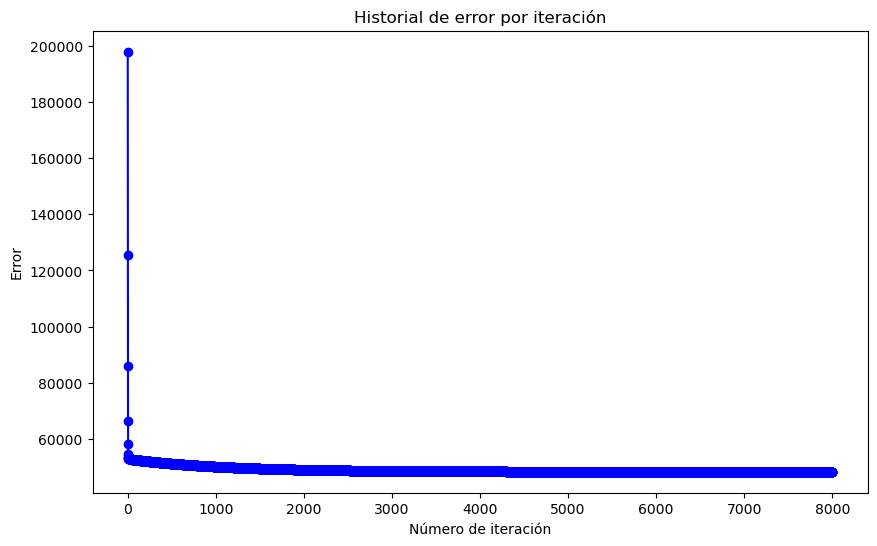

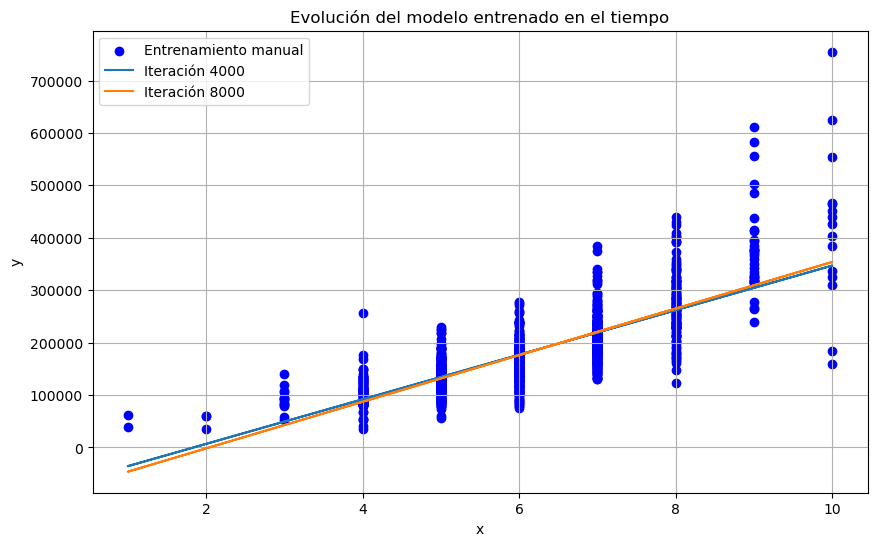

In [20]:
print(historial_error_1[len(historial_error_1)]) # Ultimo error
regresion.grafica_historial_error(historial_error_1)
regresion.graficar_historial_modelo(historial_parametros_1, 4000, X1_Entrenamiento, Y_Entrenamiento)

### Entrenando la variable 2 donde Y es SalePrice y X es 1stFlrSF

In [21]:
regresion2 = Regresion()

In [22]:
X2_Entrenamiento = dataset_entrenamiento[:,2]
Y_Entrenamiento = dataset_entrenamiento[:,0]

In [23]:
historial_parametros_2, historial_error_2 = regresion2.calcular_gradiente(X2_Entrenamiento, Y_Entrenamiento, 13, 10, 0.0000001)

Iteration No. 10: Error 77782.55253074337, Parametros (0,1) 122.71353140103186, 0.19936294180938968


69748.91077609468


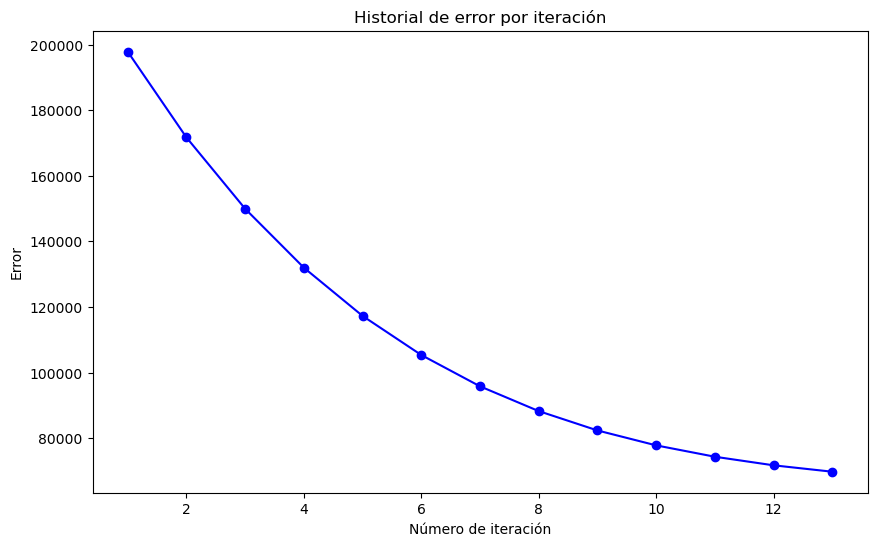

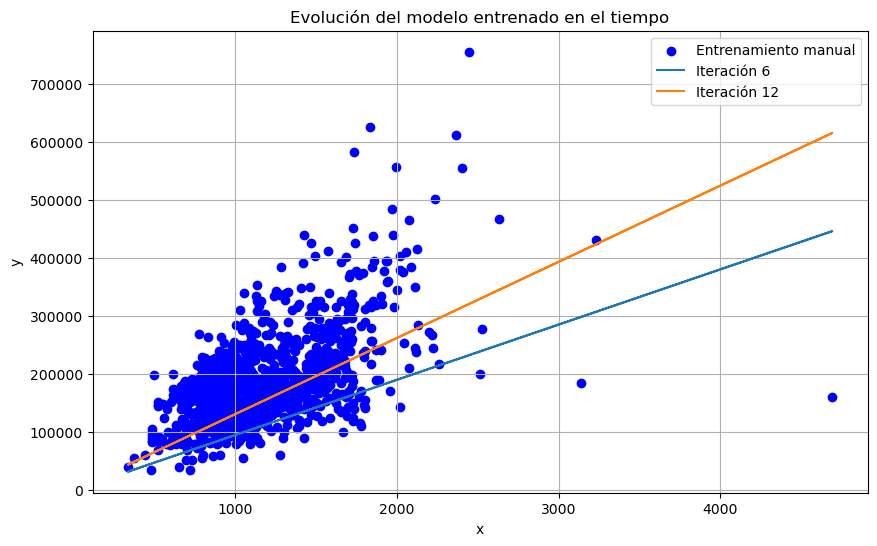

In [24]:
print(historial_error_2[len(historial_error_2)]) # Ultimo error
regresion.grafica_historial_error(historial_error_2)
regresion.graficar_historial_modelo(historial_parametros_2, 6, X2_Entrenamiento, Y_Entrenamiento)

### Para cada una de las variables utilizar Scikit-Learn

In [25]:
# La función para calcular se define en la Clase Regresión
sklearn_parametros_1, sklearn_y_pred_1 = regresion.sklearn_calcular_gradiente(X1_Entrenamiento, Y_Entrenamiento)
sklearn_parametros_2, sklearn_y_pred_2 = regresion2.sklearn_calcular_gradiente(X2_Entrenamiento, Y_Entrenamiento)

2343698619.751806
3975614195.338531


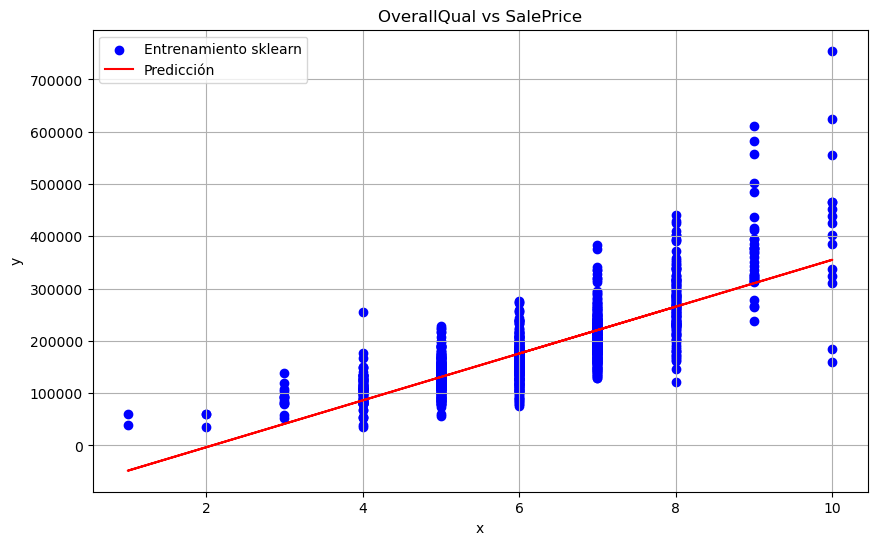

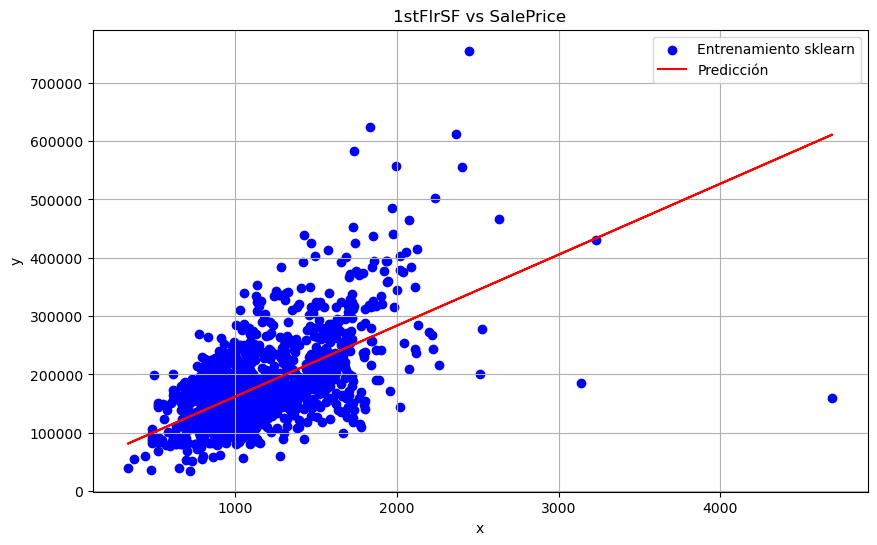

In [26]:
# La función para graficar se define en la Clase Regresión
regresion.sklearn_graficar_modelo(X1_Entrenamiento, Y_Entrenamiento, sklearn_y_pred_1, 'OverallQual')
regresion2.sklearn_graficar_modelo(X2_Entrenamiento, Y_Entrenamiento, sklearn_y_pred_2, '1stFlrSF')

### Para cada variable independiente x elegida, crear una función que usando el modelo entrenado manualmente y el modelo de scikit-learn(enviados como parámetros a la función) calcule la estimación o predicción de cada uno de estos y devuelva como resultado una predicción estimada promediando las predicciones de los 2 modelos, la función debe recibir como parámetro adicional un vector de cualquier tamanño de x y devolver 3 vectores cada uno del mismo tamaño del vector x, estos vectores son:

##### La predicción con el modelo entrenado manualmente 
##### La predicción con el modelo de scikit-learn
##### La combinación(promedio) de las 2 anteriores.

#### Calculamos el promedio para la variable X1

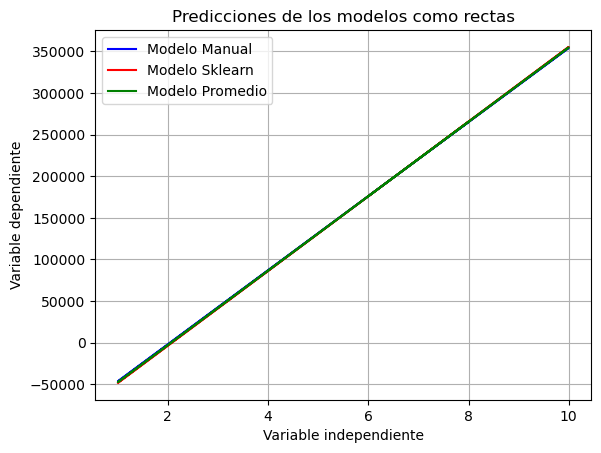

In [27]:
y_pred_manual, y_pred_sklearn, y_promedio = regresion.calcular_promedio_prediciones(regresion.y_pred_manual, regresion.y_pred_sklearn, X1_Entrenamiento)
regresion.graficar_promedio_predicciones(y_pred_manual, y_pred_sklearn, y_promedio, X1_Entrenamiento)

#### Calculamos el promedio para la variable X2

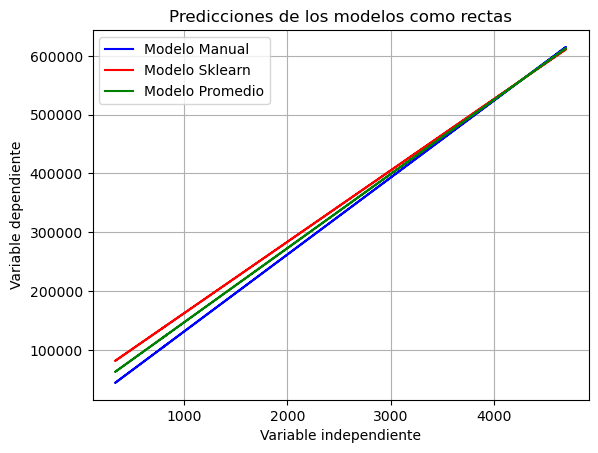

In [28]:
y_pred_manual, y_pred_sklearn, y_promedio = regresion2.calcular_promedio_prediciones(regresion2.y_pred_manual, regresion2.y_pred_sklearn, X2_Entrenamiento)
regresion2.graficar_promedio_predicciones(y_pred_manual, y_pred_sklearn, y_promedio, X2_Entrenamiento)

## Validación del Modelo

#### Calcular el coeficiente de correlacion de las variables de validación

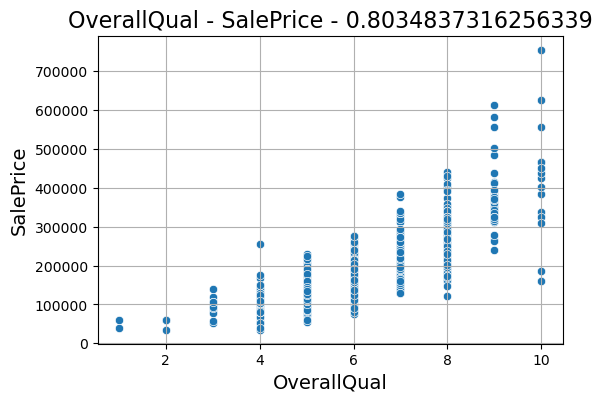

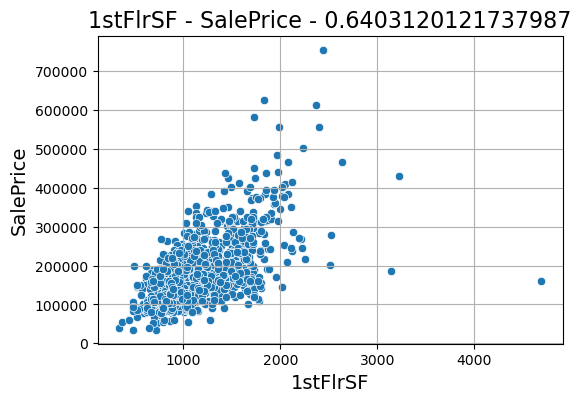

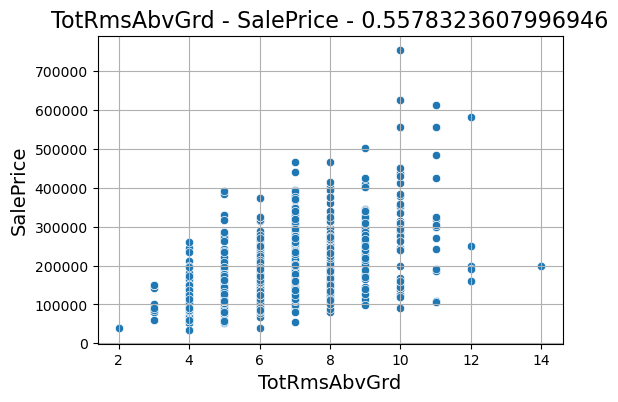

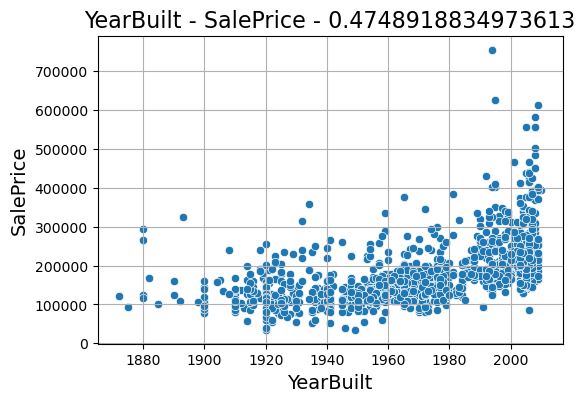

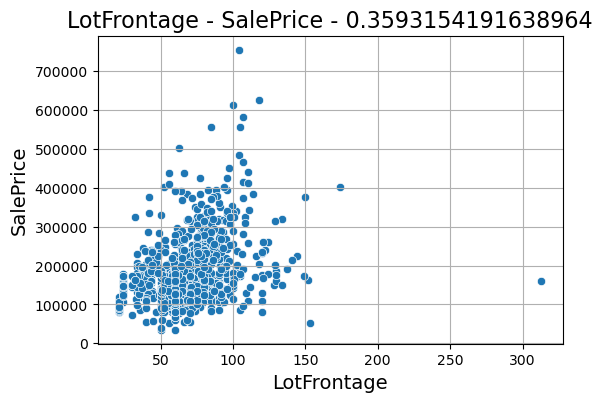

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
SalePrice,1.000000,0.803484,0.640312,0.557832,0.474892,0.359315
OverallQual,0.803484,1.000000,0.506279,0.414618,0.544929,0.247649
1stFlrSF,0.640312,0.506279,1.000000,0.416533,0.235086,0.421170
TotRmsAbvGrd,0.557832,0.414618,0.416533,1.000000,0.044589,0.330533
YearBuilt,0.474892,0.544929,0.235086,0.044589,1.000000,0.103384
LotFrontage,0.359315,0.247649,0.421170,0.330533,0.103384,1.000000


In [29]:
calcular_cociente_correlacion(dfValidacion)

### Validando la variable 1 donde Y es SalePrice y X es OverallQual 

In [107]:
regresion_validacion = Regresion()

In [108]:
X1_Validacion = dataset_validacion[:,1]
Y_Validacion = dataset_validacion[:,0]

In [109]:
historial_parametros_1, historial_error_1 = regresion_validacion.calcular_gradiente(X1_Validacion, Y_Validacion, 8000, 2000, 0.01)

Iteration No. 2000: Error 49991.20341831744, Parametros (0,1) 41253.797931492554, -66614.42215163734
Iteration No. 4000: Error 49189.2636747673, Parametros (0,1) 45508.21963053815, -93423.86598232668
Iteration No. 6000: Error 49075.03119741167, Parametros (0,1) 47106.48636549662, -103495.42101104908
Iteration No. 8000: Error 49058.8882198277, Parametros (0,1) 47706.91028601397, -107279.02134745276


49916.81366561522


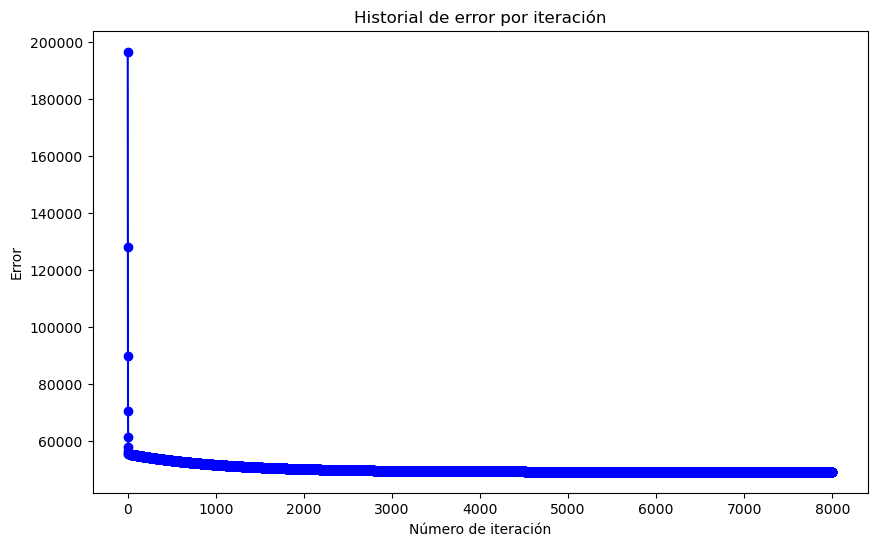

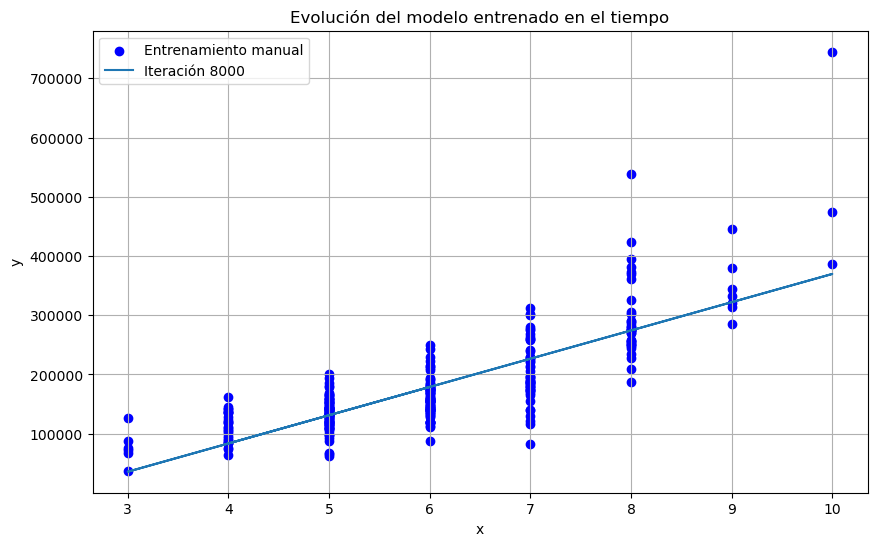

In [111]:
print(sum(historial_error_1.values()) / len(historial_error_1))
regresion_validacion.grafica_historial_error(historial_error_1)
regresion_validacion.graficar_historial_modelo(historial_parametros_1, 8000, X1_Validacion, Y_Validacion)

### Validando la variable 2 donde Y es SalePrice y X es 1stFlrSF

In [112]:
regresion_validacion2 = Regresion()

In [113]:
X2_Validacion = dataset_validacion[:,2]
Y_Validacion = dataset_validacion[:,0]

In [114]:
historial_parametros_2, historial_error_2 = regresion_validacion2.calcular_gradiente(X2_Validacion, Y_Validacion, 13, 10, 0.0000001)

Iteration No. 10: Error 75831.90323030425, Parametros (0,1) 121.80163101712837, 0.19503251604637373


108230.06247994638


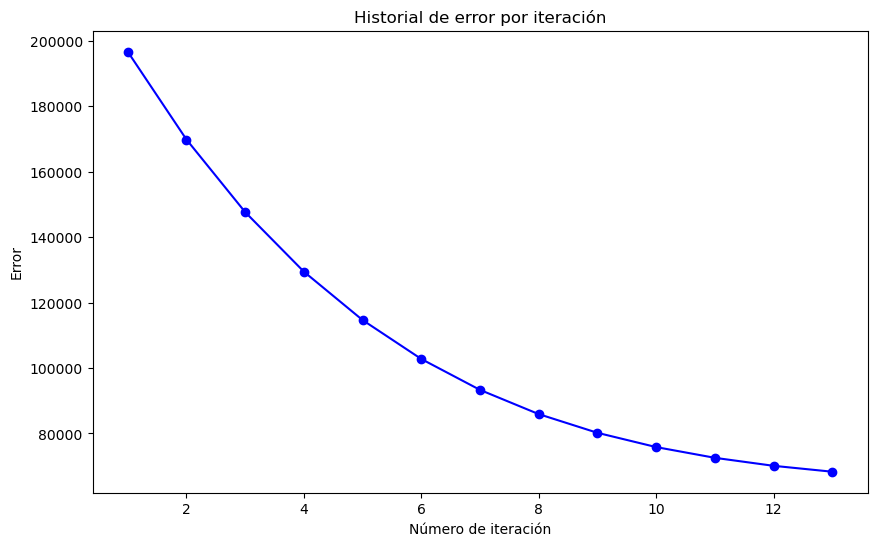

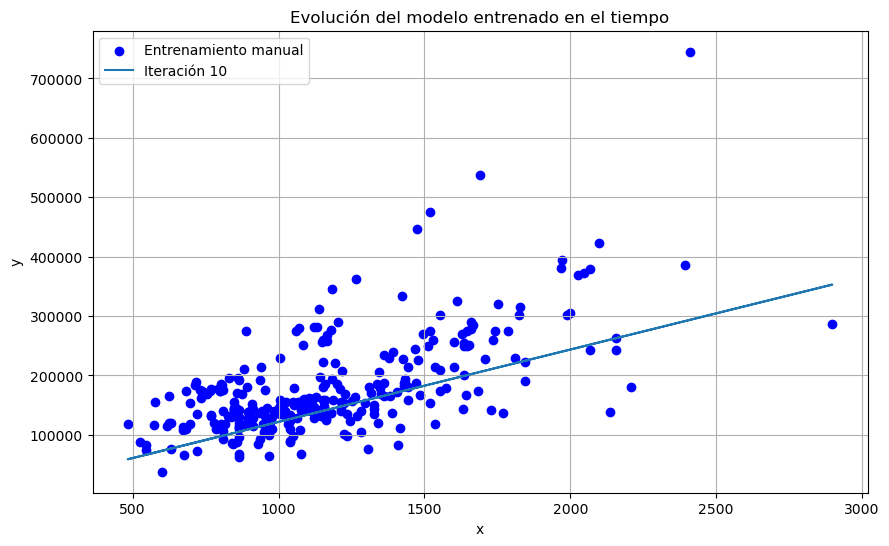

In [115]:
print(sum(historial_error_2.values()) / len(historial_error_2)) # Ultimo error
regresion_validacion2.grafica_historial_error(historial_error_2)
regresion_validacion2.graficar_historial_modelo(historial_parametros_2, 10, X2_Validacion, Y_Validacion)

### Validando el Modelo con Scikit-Learn

In [116]:
# La función para calcular se define en la Clase Regresión
sklearn_parametros_1, sklearn_y_pred_1 = regresion_validacion.sklearn_calcular_gradiente(X1_Validacion, Y_Validacion)
sklearn_parametros_2, sklearn_y_pred_2 = regresion_validacion2.sklearn_calcular_gradiente(X2_Validacion, Y_Validacion)

2406514202.3806505
4006176608.162462


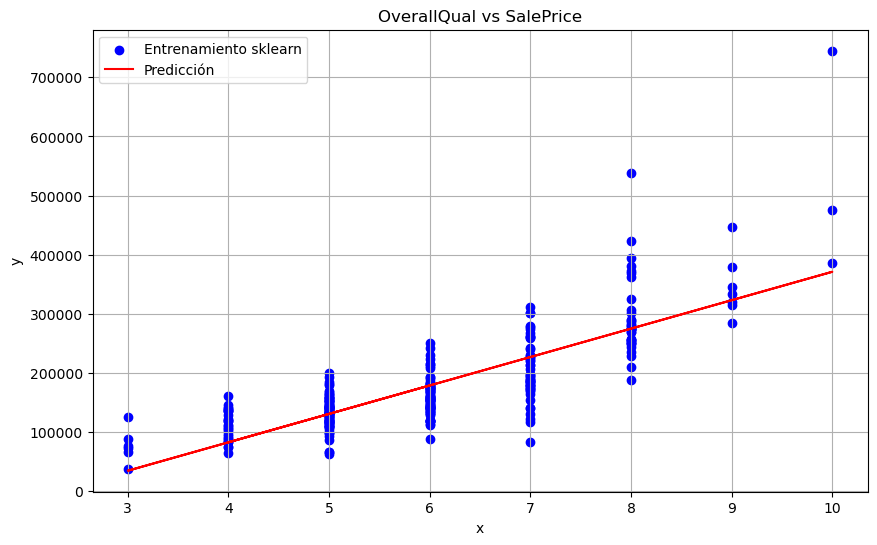

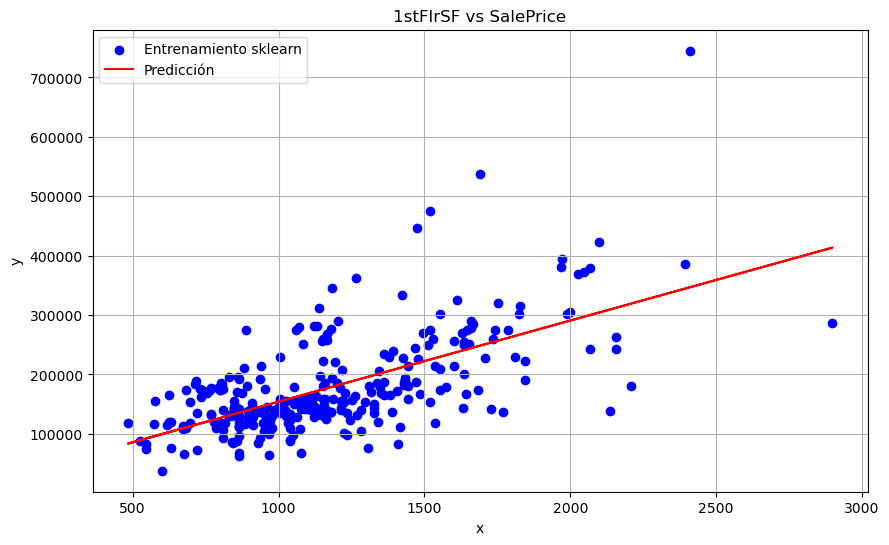

In [117]:
# La función para graficar se define en la Clase Regresión
regresion_validacion.sklearn_graficar_modelo(X1_Validacion, Y_Validacion, sklearn_y_pred_1, 'OverallQual')
regresion_validacion2.sklearn_graficar_modelo(X2_Validacion, Y_Validacion, sklearn_y_pred_2, '1stFlrSF')

### Conclusión

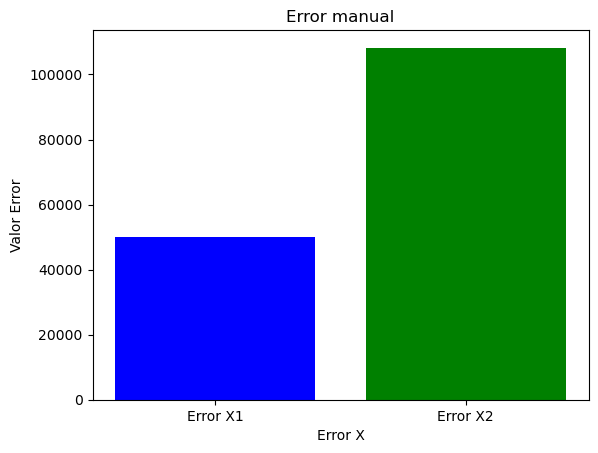

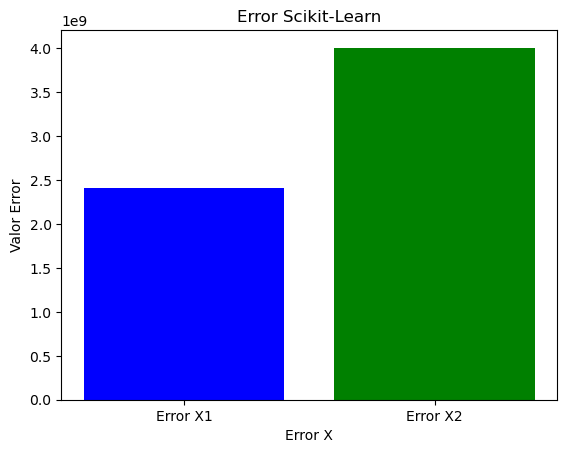

In [124]:
regresion_error = Regresion()

regresion_error.comparar_errores(sum(historial_error_1.values()) / len(historial_error_1), sum(historial_error_2.values()) / len(historial_error_2), 'Error manual')
regresion_error.comparar_errores(regresion_validacion.error_sklearn, regresion_validacion2.error_sklearn, 'Error Scikit-Learn')

#### Despues de entrenar el modelo de forma manual y utilizando Scikit-Learn, a la vez se ha validado el modelo de ambas formas. Se concluye que el modelo con la variable independiente X = OverallQual y Y = SalePrice es el modelo con mejor resultado debido a que presenta el error mas bajo.